# SPECTROGRAM

## 1. 데이터 준비

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [3]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  48781
Wave data shape :  (8000,)
label :  ['silence']


In [4]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

In [5]:
temp = []
for v in speech_data["label_vals"][: 30000]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

## 2.  2차원 SPECTOGRAM으로 전환

In [6]:
import librosa

def wav2spec(wav, fft_size=550): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

In [7]:
spec = []
s_data = speech_data['wav_vals'][:30000]
for data in s_data:
    wav_data = wav2spec(data)
    spec.append(wav_data)
    
spec = np.array(spec)
print(spec.shape)

(30000, 276, 59)


## 3. train data test data 분리하기

In [8]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(spec, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

[[[7.64200184e-03 2.53511383e-03 1.40947779e-03 ... 7.91144033e-04
   3.12724779e-03 1.44859841e-02]
  [9.16511938e-03 5.59150893e-03 1.58209912e-03 ... 3.39764752e-03
   1.66817440e-03 1.68915186e-02]
  [1.03972284e-02 5.15504042e-03 2.00863881e-03 ... 3.00476793e-03
   6.32469822e-03 2.27448829e-02]
  ...
  [8.70972965e-03 4.39698296e-03 2.04263979e-05 ... 1.03931990e-04
   1.07304042e-03 4.22614999e-03]
  [8.55406933e-03 4.27911989e-03 1.06980660e-04 ... 4.52636414e-05
   8.95287725e-04 4.05634614e-03]
  [8.43858346e-03 4.23028553e-03 5.82538887e-05 ... 7.66035082e-05
   9.92961111e-04 4.02329443e-03]]

 [[3.45738101e+00 2.56080627e+00 1.46471828e-01 ... 1.84122705e+00
   3.20890927e+00 3.55794764e+00]
  [1.73700309e+00 2.05581260e+00 1.82289100e+00 ... 6.67634058e+00
   6.95263815e+00 4.15738726e+00]
  [3.08620334e-01 7.09352195e-01 9.22242463e-01 ... 1.05851574e+01
   8.64546108e+00 1.94899476e+00]
  ...
  [1.01936357e-02 5.09293843e-03 4.27193982e-06 ... 9.34740019e-05
   9.04695

In [9]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)

train data :  (27000, 276, 59)
train labels :  (27000,)
test data :  (3000, 276, 59)
test labels :  (3000,)


In [10]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

In [11]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [12]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 276, 59), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 276, 59), (None, 12)), types: (tf.float32, tf.float32)>


## 4. 모델 설계하기

In [13]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(276, 59))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 276, 59)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 276, 32)           17024     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 276, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 138, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 138, 64)           18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 138, 64)           36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 69, 64)            0     

In [14]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

## 5. 모델 train 하기

In [16]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
209/210 [============================>.] - ETA: 0s - loss: 1.7564 - accuracy: 0.3951
Epoch 00001: val_loss improved from inf to 2.13786, saving model to /home/aiffel0038/aiffel/speech_recognition/models/wav
210/210 [==============================] - 5s 24ms/step - loss: 1.7554 - accuracy: 0.3954 - val_loss: 2.1379 - val_accuracy: 0.5350
Epoch 2/10
208/210 [============================>.] - ETA: 0s - loss: 1.1509 - accuracy: 0.6021
Epoch 00002: val_loss improved from 2.13786 to 1.36956, saving model to /home/aiffel0038/aiffel/speech_recognition/models/wav
210/210 [==============================] - 5s 23ms/step - loss: 1.1490 - accuracy: 0.6029 - val_loss: 1.3696 - val_accuracy: 0.6675
Epoch 3/10
208/210 [============================>.] - ETA: 0s - loss: 0.7262 - accuracy: 0.7552
Epoch 00003: val_loss improved from 1.36956 to 0.68722, saving model to /home/aiffel0038/aiffel/speech_recognition/models/wav
210/210 [==============================] - 5s 23ms/step - loss: 0.7243 - a

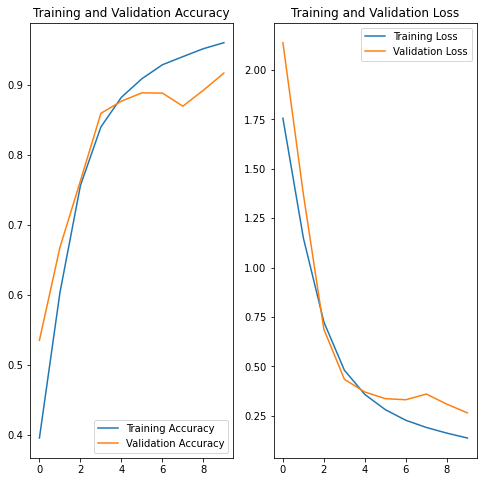

In [17]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [18]:
model_wav.load_weights(checkpoint_dir)

In [31]:
results = model_wav.evaluate(test_dataset)

24/24 [==============================] - 0s 7ms/step - loss: 0.2637 - accuracy: 0.9167


In [32]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

loss value: 0.264
accuracy value: 91.6667%


In [33]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

label :  left


In [34]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: left


---

## 7. skip-connection model 설계하기

In [23]:
input_tensor = layers.Input(shape=(276, 59))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 276, 59)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 276, 32)      17024       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 276, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 138, 32)      0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [24]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


In [25]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)


## 8. skip-connection model train 하기

In [26]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )


Epoch 1/10
208/210 [============================>.] - ETA: 0s - loss: 1.8243 - accuracy: 0.3818
Epoch 00001: val_loss improved from inf to 1.54870, saving model to /home/aiffel0038/aiffel/speech_recognition/models/wav_skip
210/210 [==============================] - 5s 26ms/step - loss: 1.8207 - accuracy: 0.3827 - val_loss: 1.5487 - val_accuracy: 0.4766
Epoch 2/10
209/210 [============================>.] - ETA: 0s - loss: 1.1341 - accuracy: 0.6086
Epoch 00002: val_loss improved from 1.54870 to 0.91552, saving model to /home/aiffel0038/aiffel/speech_recognition/models/wav_skip
210/210 [==============================] - 5s 25ms/step - loss: 1.1333 - accuracy: 0.6087 - val_loss: 0.9155 - val_accuracy: 0.6889
Epoch 3/10
208/210 [============================>.] - ETA: 0s - loss: 0.6954 - accuracy: 0.7658
Epoch 00003: val_loss improved from 0.91552 to 0.56753, saving model to /home/aiffel0038/aiffel/speech_recognition/models/wav_skip
210/210 [==============================] - 5s 25ms/step - l

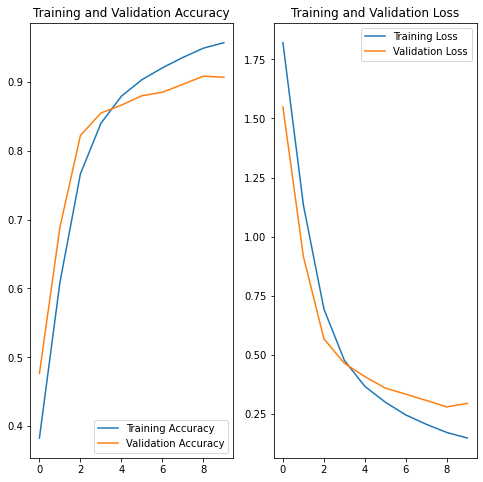

In [27]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


24/24 [==============================] - 3s 110ms/step - loss: 0.2776 - accuracy: 0.9087
loss value: 0.278
accuracy value: 90.8667%


In [29]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))


label :  right


In [30]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))

y_pred: right


spectagram을 이용하게 되면 2차원 데이터를 이용하므로 더 나은 성능이 보장되며 훈련 속도가 빨라진다.     
이와는 별개로 skip-connection같은 경우 Residual block을 이용했다는 점에서  ResNet과 상당히 유사하다고 생각했다.   
음성이든 이미지이든 컨텐츠만 달라지고 이용하는 딥러닝 모델과 설계방식이 비슷하다는 것을 느끼고 있다.